This notebooks aims to create smoothed CH4 plume mask. We use the [PRISMA control release](https://doi.org/10.1038/s41598-023-30761-2) case as an example.

In [1]:
from hyperch4 import Hyper

from glob import glob
import xarray as xr
import numpy as np
import pyresample
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
from pyresample.geometry import SwathDefinition

plt.rcParams['image.cmap'] = 'RdBu_r'
# plt.style.use('dark_background')
plt.rcParams.update({'axes.titlesize': 'xx-large'})

## Load Data and Run Retrieval

In [2]:
data_dir = '/Users/xinz/Documents/github/HyperCH4/test_data/'

In [3]:
filename = glob(data_dir+'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001.he5')
hyp = Hyper(filename, reader='hyc_l1')

# filename = glob('/Users/xinz/Documents/data/LOW_cities/Philippiines/Manila/EMIT_*001_20230623T045729_2317403_032*')
# hyp = Hyper(filename, reader='emit_l1b')

hyp.load()

/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [4]:
hyp.retrieve(wvl_intervals=[1300, 2500])
ch4_swir = hyp.scene['ch4'].isel(bands=0)
hyp.retrieve(wvl_intervals=[2100, 2450])
hyp.scene['ch4'] = hyp.scene['ch4'].isel(bands=0)
ch4 = hyp.scene['ch4']

In [5]:
diff = ch4_swir - ch4
scale = ch4.std()/ch4_swir.std()
# scale if ch4_swir < ch4
hyp.scene['ch4_comb'] = ch4.where(diff>0, ch4_swir*scale).rename('ch4_comb')

In [6]:
ds = hyp.scene.to_xarray(datasets=['u10', 'v10', 'rgb', 'ch4', 'ch4_comb'])

In [7]:
# Pick source manually
lon_sample = -114.489233
lat_sample = 33.631165

## Create Wind Weights

In [8]:
def get_wind_azimuth(u,v):
      if (u>0):
         azim_rad = (np.pi)/2. - np.arctan(v/u)
      elif (u==0.):
         if (v>0.): azim_rad = 0.
         elif (v==0.): azim_rad = 0.
         elif (v<0.): azim_rad = np.pi
      elif(u<0.):
         azim_rad = 3*np.pi/2. + np.arctan(-v/u)

      azim = azim_rad*180./np.pi

      return azim_rad, azim

wind_source = 'ERA5'

angle_wind_rad, angle_wind = get_wind_azimuth(ds['u10'].sel(source=wind_source).item(),
                                              ds['v10'].sel(source=wind_source).item())

In [9]:
def conish_2d(x,y,xc,yc,r,ws):

   xr = (x-xc)*np.cos(r) + (y-yc)*np.sin(r)
   yr = -(x-xc)*np.sin(r) + (y-yc)*np.cos(r)

   max_xr = np.max(np.abs(xr))
   max_yr = np.max(np.abs(yr))

   t = np.arctan2(yr,xr)

   scale_dist = max(max_xr,max_yr)
   orig_shift = -scale_dist/10.
   t = np.arctan2(yr,xr-orig_shift)
   sig = scale_dist/2.

   open_ang = np.pi/3.5

   out = np.exp( -( (xr-orig_shift)**2 + (yr)**2 )/sig**2 - (t/open_ang)**2 )

   return out

weights = conish_2d(ds['longitude'], ds['latitude'], lon_sample, lat_sample, np.pi/2.-angle_wind_rad, angle_wind)

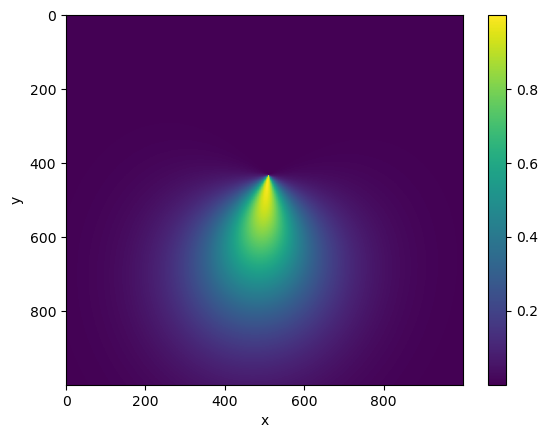

In [10]:
weights.plot.imshow(origin='upper')

## Denoise and Apply the Wind Weights

In [11]:
def smooth(data):
    return denoise_tv_chambolle(data, weight=50)

# get index of nan values
null_idx = np.where(ds['ch4_comb'].isnull().all('x'))[0]

if len(null_idx) > 0:
    # calculate the difference
    bnd_idx = np.where(np.diff(null_idx) > 1)[0]

    # get the null index bound and next value
    split_idx = np.sort(np.concatenate((null_idx[bnd_idx], null_idx[bnd_idx+1]-1)))
    # add the index-1 of first nan value
    split_idx = np.insert(split_idx, 0, null_idx[0]-1)
    # add the index of last nan value
    split_idx = np.append(split_idx, null_idx[-1])
    # add first index
    split_idx = np.insert(split_idx, 0, 0)
    # add last index
    split_idx = np.append(split_idx, ds['ch4_comb'].sizes['y']-1)

    ch4_denoise = ds['ch4_comb'].groupby_bins('y', split_idx, include_lowest=True).map(smooth)
else:
    ch4_denoise = smooth(ds['ch4_comb'])

In [12]:
ch4_weights = ch4_denoise*weights

Text(0.5, 1.0, 'TV filter with wind weights')

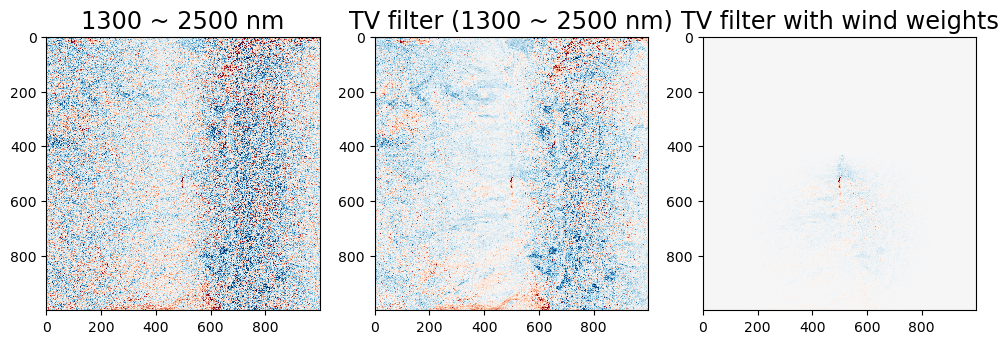

In [13]:
vmin = -600
vmax = 600

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs = axs.flatten()

ax = axs[0]
m = ax.imshow(ds['ch4_comb'], vmin=vmin, vmax=vmax, interpolation='none')
ax.set_title('1300 ~ 2500 nm')

ax = axs[1]
m = ax.imshow(ch4_denoise, vmin=vmin, vmax=vmax, interpolation='none')
ax.set_title('TV filter (1300 ~ 2500 nm)')

ax = axs[2]
m = ax.imshow(ch4_weights, vmin=vmin, vmax=vmax, interpolation='none')
ax.set_title('TV filter with wind weights')

# plt.tight_layout()
# fig.savefig('tmp.png', transparent=True)

## Create the Initial Mask with Median/Gaussian Filter

In [14]:
# set init mask
quantile_value = 0.995
mask_buf = np.zeros(np.shape(ch4))
mask_buf[ ch4_weights >= ch4_weights.quantile(quantile_value)] = 1.

# blur the mask
size_median = 3
sigma_guass = 2
median_blurred = ndimage.median_filter(mask_buf, size_median)
gaussmed_blurred = ndimage.gaussian_filter(median_blurred, sigma_guass)

Text(0.5, 1.0, 'Gaussian filter (sigma=2)')

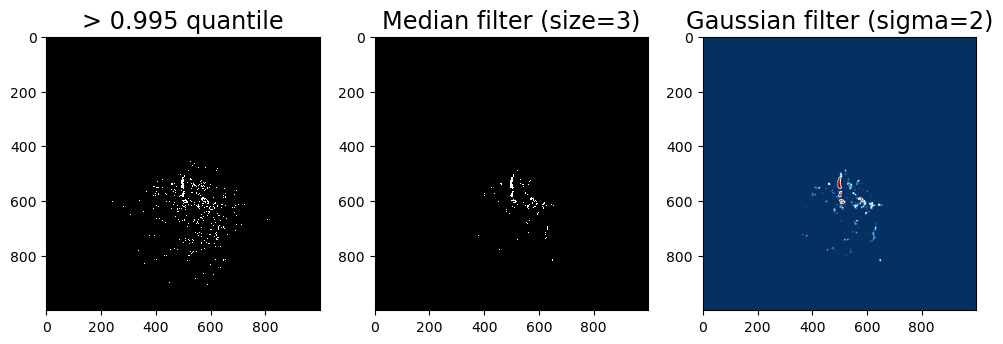

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs = axs.flatten()

ax = axs[0]
m = ax.imshow(mask_buf, interpolation='none', cmap='Greys_r')
ax.set_title(f'> {quantile_value} quantile')

ax = axs[1]
m = ax.imshow(median_blurred, interpolation='none', cmap='Greys_r')
ax.set_title(f'Median filter (size={size_median})')

ax = axs[2]
m = ax.imshow(gaussmed_blurred, interpolation='none')
ax.set_title(f'Gaussian filter (sigma={sigma_guass})')

## Label Mask and Pick Mask Containing Source

In [16]:
mask = np.zeros(np.shape(ch4))
mask[gaussmed_blurred>0.05] = 1.
mask_gauss_large = mask

# dilation
niter = 1
if niter > 0:
    mask_dilation = ndimage.binary_dilation(mask_gauss_large, iterations=niter)
else:
    mask_dilation = mask_buf

# assign labels by 3x3
npixel = 3
labeled_mask, nfeatures = ndimage.label(mask_dilation, structure=np.ones((npixel, npixel)))

In [17]:
area_source = SwathDefinition(lons=ds['longitude'], lats=ds['latitude'])
area_target = SwathDefinition(lons=np.array([lon_sample]), lats=np.array([lat_sample]))

# Determine nearest (w.r.t. great circle distance) neighbour in the grid.
_, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
    source_geo_def=area_source, target_geo_def=area_target, radius_of_influence=50,
    neighbours=1)
# get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
y_sample, x_sample = np.unravel_index(index_array, area_source.shape)

# y_sample, x_sample = get_sample_index(ds, lon_sample, lat_sample)
feature_label = labeled_mask[y_sample, x_sample]
mask = labeled_mask==feature_label

In [18]:
y_sample, x_sample

(array([500]), array([502]))

Text(0.5, 1.0, 'mask containing the source point')

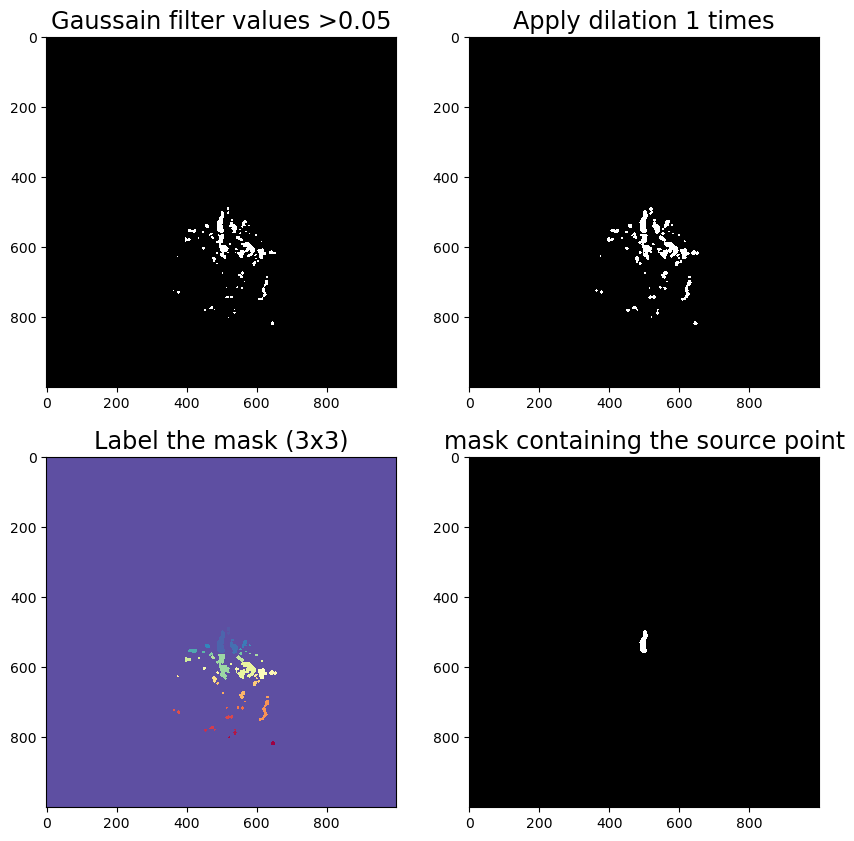

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = axs.flatten()

ax = axs[0]
m = ax.imshow(mask_gauss_large, interpolation='none', cmap='Greys_r')
ax.set_title(f'Gaussain filter values >0.05')

ax = axs[1]
m = ax.imshow(mask_dilation, interpolation='none', cmap='Greys_r')
ax.set_title(f'Apply dilation {niter} times')

ax = axs[2]
m = ax.imshow(labeled_mask, interpolation='none', cmap='Spectral_r')
ax.set_title(f'Label the mask ({npixel}x{npixel})')

ax = axs[3]
m = ax.imshow(mask, interpolation='none', cmap='Greys_r')
ax.set_title(f'mask containing the source point')

Text(0.5, 1.0, 'Masked data \n (2100 ~ 2450 nm)')

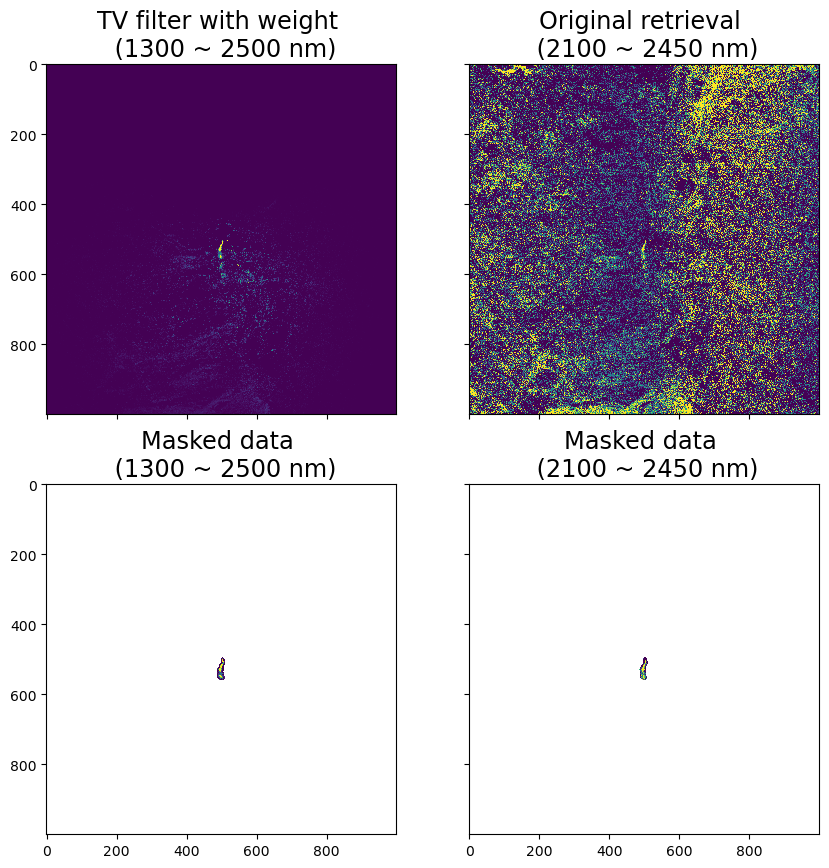

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

ax = axs[0]
m = ax.imshow(ch4_weights, vmin=0, vmax=300, interpolation='none', cmap='viridis')
ax.set_title(f'TV filter with weight \n (1300 ~ 2500 nm)')

ax = axs[1]
m = ax.imshow(ds['ch4'], vmin=0, vmax=300, interpolation='none', cmap='viridis')
ax.set_title(f'Original retrieval \n (2100 ~ 2450 nm)')

ax = axs[2]
m = ax.imshow(ch4_weights.where(mask), vmin=0, vmax=300, interpolation='none', cmap='viridis')
ax.set_title(f'Masked data \n (1300 ~ 2500 nm)')

ax = axs[3]
m = ax.imshow(ds['ch4'].where(mask), vmin=0, vmax=300, interpolation='none', cmap='viridis')
ax.set_title(f'Masked data \n (2100 ~ 2450 nm)')

# ax.set_xlim(400, 600)
# ax.set_ylim(650, 450)

In [27]:
# plume = ds['ch4'].where(xr.DataArray(mask, dims=list(ds['ch4'].dims)))

# ds['plume'] = plume

# from hyperch4.folium_map import Map

# m = Map(ds, varnames=['plume'], center_map=[lat_sample, lon_sample])
# m.initialize()
# m.plot(show_layers=[True], opacities=[0.9],
#     marker=[lat_sample, lon_sample], draw_polygon=False)

## Remove Noise and Negative Boundary Values

In [23]:
test = ch4_weights.where(mask).isel(x=slice(400, 600), y=slice(450, 650)).dropna(dim='x', how='all').dropna(dim='y', how='all')
test_original = ds['ch4'].where(mask).isel(x=slice(400, 600), y=slice(450, 650)).dropna(dim='x', how='all').dropna(dim='y', how='all')

In [24]:
fg_mask = test > 0

open_square = ndimage.binary_opening(fg_mask)
eroded_square = ndimage.binary_erosion(fg_mask)
reconstruction = ndimage.binary_propagation(eroded_square, mask=fg_mask)
filled = ndimage.binary_fill_holes(reconstruction)

Text(0.5, 1.0, 'Masked data')

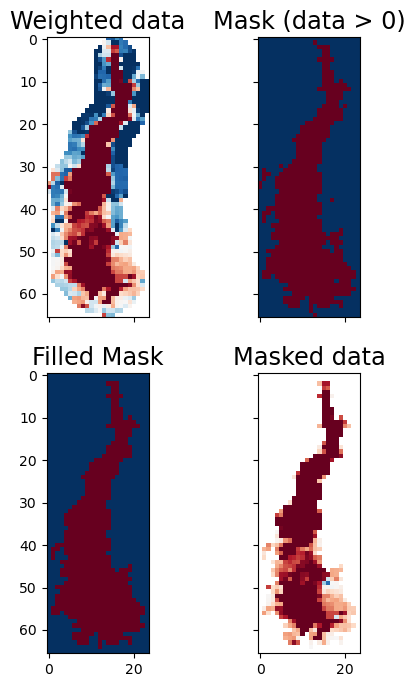

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 8), sharex=True, sharey=True)
axs = axs.flatten()

ax = axs[0]
ax.imshow(test, vmin=-100, vmax=100, cmap='RdBu_r', interpolation='none')
ax.set_title('Weighted data')

ax = axs[1]
ax.imshow(fg_mask)
ax.set_title('Mask (data > 0)')

ax = axs[2]
ax.imshow(filled)
ax.set_title('Filled Mask')

ax = axs[3]
ax.imshow(np.where(filled, test, np.nan), vmin=-100, vmax=100, cmap='RdBu_r', interpolation='none')
ax.set_title('Masked data')

Text(0.5, 1.0, 'Masked original data')

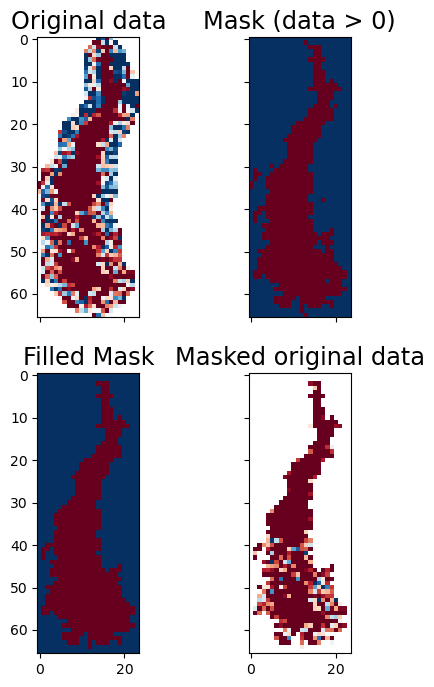

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 8), sharex=True, sharey=True)
axs = axs.flatten()

ax = axs[0]
ax.imshow(test_original, vmin=-100, vmax=100, cmap='RdBu_r', interpolation='none')
ax.set_title('Original data')

ax = axs[1]
ax.imshow(fg_mask)
ax.set_title('Mask (data > 0)')

ax = axs[2]
ax.imshow(filled)
ax.set_title('Filled Mask')

ax = axs[3]
ax.imshow(np.where(filled, test_original, np.nan), vmin=-100, vmax=100, cmap='RdBu_r', interpolation='none')
ax.set_title('Masked original data')